# **Hate Speech and Offencive Message Classifier using RBERTa**

# Introduction

Hate speech and offensive language have become major concerns in online communities, as they harm individuals and disrupt healthy discussions.This project focuses on building a **Hate Speech & Offensive Message Classifier** using **RoBERTa**, a state-of-the-art transformer model for natural language understanding.The goal is to automatically detect and classify messages containing hate speech, offensive remarks, or neutral content to assist in moderation and promote respectful communication.

# Objectivies



* Preprocess and clean Twitter text data (hashtags, mentions, links, emojis).

* Fine-tune a pre-trained RoBERTa model.

* Address class imbalance using weighted loss.

* Evaluate model performance using precision, recall, and F1-score for each class.

* Save and prepare the trained model for deployment.






# Dataset

### Source:


[Hate Speech and Offensive Language Dataset](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset)(Davidson et al., 2017) – Twitter-based dataset, available on Kaggle.

Original paper: Davidson, T., Warmsley, D., Macy, M., & Weber, I. (2017). Automated Hate Speech Detection and the Problem of Offensive Language.

### Dataset Statistics:

* Total Tweets: 24,783
* Classes:

  0 – Neither (neutral)(4163)

  1 – Hate Speech / Offensive(20620) (merged from original hate speech & offensive categories for binary classification in our model)
* Average Tweet Length: ~86 characters
* Language: English


### Dataset Split:

* Training Set: 70% (17,348 tweets) – model training
* Validation Set: 15% (3,717 tweets) – hyperparameter tuning
* Test Set: 15% (3,718 tweets) – final evaluation on unseen data

### Preprocessing Steps:
* Label mapping: 0 = Neither, 1 = Hate/Offensive.
* Text cleaning and normalization with Discord-specific preprocessing.
* Train/validation/test split.
* Tokenization with RoBERTa tokenizer.
* Dynamic padding and truncation.


### Model: RoBERTa

We fine-tuned the roberta-base model from Hugging Face Transformers for binary classification.To handle class imbalance, a weighted CrossEntropyLoss was applied based on label frequency in the training set.

### Evaluation Metrics

The model was evaluated using standard classification metrics:

* Precision
* Recall
* F1-score
* Accuracy
* Acceptance Criteria:

The model will be considered acceptable if the **F1-score** for the hate/offensive class exceeds **0.90** on the test dataset, ensuring effective detection while minimizing false positives.

### Output

### Integration with Amy (Discord Bot)
This hate/offensive language classifier will be integrated into **Amy** — an intelligent Discord bot capable of:

* Detecting toxic and harmful messages in real-time.
* Taking automated moderation actions.
* Working alongside the spam detection model for complete chat moderation

# Preparing Tools

In [ ]:
!pip install transformers datasets optuna scikit-learn matplotlib seaborn pandas torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import Liberies

In [ ]:
# General libraries
import pandas as pd
import numpy as np
import random
import re
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Sklearn - preprocessing, splitting, evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight


# Hugging Face Transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding


# Hugging Face Datasets
from datasets import Dataset, DatasetDict, load_dataset

# PyTorch (used by Transformers)
import torch
from torch import nn
from torch.utils.data import DataLoader

# Optuna for hyperparameter tuning
import optuna

from tqdm import tqdm  # for progress bars
import warnings
warnings.filterwarnings("ignore")


In [ ]:
def preprocess_text(text: str) -> str:
    text = re.sub(r"(https?:\/\/)?(www\.)?(discord\.(gg|io|me|li)|discordapp\.com\/invite)\/\S+", "<DISCORD_INVITE>", text)  # Discord invites first
    text = re.sub(r"(https?://\S+|www\.\S+)", "<URL>", text)  # URLs
    text = re.sub(r"<@!?\d+>", "<USER>", text)                # Mentions
    text = re.sub(r"<a?:\w+:\d+>", "<EMOJI>", text)           # Emojis
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Load Data

In [ ]:
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df = df[['class', 'tweet']]  # Keep only label and message
df.columns = ['label', 'text']  # Rename for consistency

# Map the labels: 2 (neither) to 0, and 0, 1 (hate or offensive) to 1
df['label'] = df['label'].map({2: 0, 0: 1, 1: 1})

display(df.head())

,label,text
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.tail()

,label,text
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,0,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies
24782,0,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [ ]:
df["label"].value_counts()

,count
label,
1,20620
0,4163


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  int64 
 1   text    24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [ ]:
df.isna().sum()

,0
label,0
text,0


# Visualize data

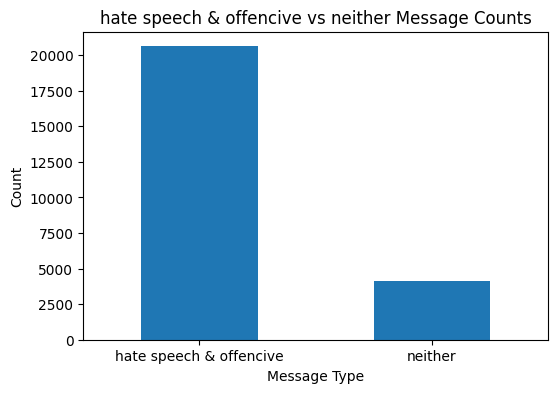

In [ ]:
df["label"].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("hate speech & offencive vs neither Message Counts")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['hate speech & offencive', 'neither'], rotation=0)
plt.show()

In [ ]:
max_length_words = df['text'].str.split().str.len().max()
longest_message_words = df.loc[df['text'].str.split().str.len().idxmax(), 'text']

print(f"Max message length (words): {max_length_words}")


Max message length (words): 52


In [ ]:
avg_length_chars = df['text'].str.len().mean()

print(f"Average message length (characters): {avg_length_chars:.2f}")

Average message length (characters): 85.44


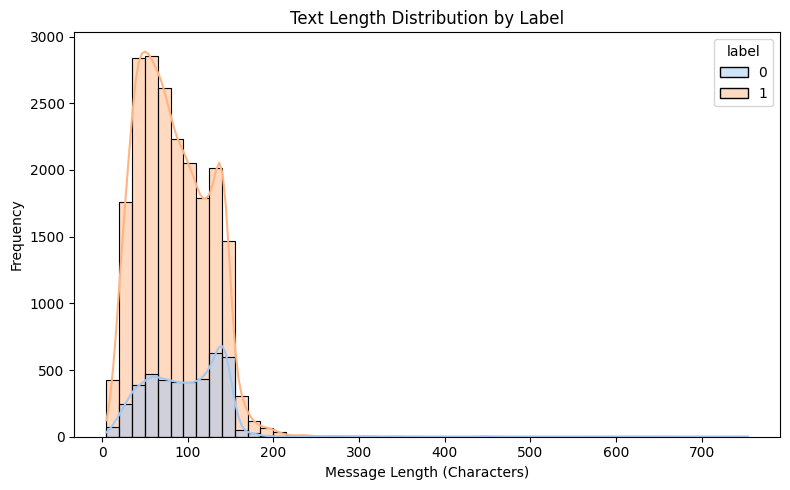

In [ ]:
df["len"] = df["text"].apply(len)

# Plot text length distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="len", hue='label', bins=50, kde=True, palette='pastel')
plt.title("Text Length Distribution by Label")
plt.xlabel("Message Length (Characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show();

# Clean Data

In [ ]:
df["text"] = df["text"].apply(preprocess_text)

In [ ]:
df

,label,text,len
0,0,!!! RT @mayasolovely: As a woman you shouldn't...,140
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,146
24779,0,"you've gone and broke the wrong heart baby, an...",70
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,67
24781,1,youu got wild bitches tellin you lies,37


# Split Dataset

In [ ]:
# split into training (70%) and temporary (30%) datasets
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,      # 30% goes to validation + test
    random_state=42,    # for reproducibility
    stratify=df['label']  # preserve class balance
)

# Then, split the temporary dataset into validation (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,          # half of temp_df -> test, half -> validation
    random_state=42,
    stratify=temp_df['label']
)


print("Training set label distribution:\n", train_df['label'].value_counts(normalize=True))
print("Validation set label distribution:\n", val_df['label'].value_counts(normalize=True))
print("Test set label distribution:\n", test_df['label'].value_counts(normalize=True))


Training set label distribution:
 label
1    0.832027
0    0.167973
Name: proportion, dtype: float64
Validation set label distribution:
 label
1    0.832123
0    0.167877
Name: proportion, dtype: float64
Test set label distribution:
 label
1    0.831899
0    0.168101
Name: proportion, dtype: float64


In [ ]:
train_df.shape, val_df.shape, test_df.shape

((17348, 3), (3717, 3), (3718, 3))

In [ ]:
train_df["label"].value_counts()

,count
label,
1,14434
0,2914


In [ ]:
val_df["label"].value_counts()

,count
label,
1,3093
0,624


In [ ]:
test_df["label"].value_counts()

,count
label,
1,3093
0,625


In [ ]:
train_df

,label,text,len
7746,1,And mad hoes you can ask Beavis I get nothing ...,54
20714,1,She be thinking she throwing that pussy back s...,101
13236,1,Never seen yo bitch but I bet I could fuck her...,63
15943,1,RT @Kalay_Laay: A side bitch made this &#12851...,89
9550,1,"Got ya crackas, spics, chinks, and carpet ride...",108
...,...,...,...
13334,1,Niggas hate me cuz they know im a threat to th...,67
326,1,"""@fIirting: HE'S DOING IT RIGHT &#128525;&#128...",98
6449,1,@kieffer_jason bitch you are not funny stfu ta...,98
8825,1,"Don't touch no sloppy hoes, You might catch so...",54


We know that in this dataset, class imbalance is high. So, we need to have weighted trainer for that.

# Compute Class Weights

In [ ]:
# Calculate class weights using TRAINING SET only
class_weights = compute_class_weight(
    class_weight='balanced',             # Adjusts weights inversely proportional to class frequency
    classes=np.unique(train_df['label']),
    y=train_df['label']
)


print(f"Class weights: {class_weights}")

# Convert to PyTorch tensor (to use in loss function)
class_weights = torch.tensor(class_weights, dtype=torch.float)

Class weights: [2.97666438 0.60094222]


# Tokenization

In [ ]:
# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(batch):
    try:
        return tokenizer(
            batch['text'],       
            truncation=True,
            max_length=200,
            padding=False,       # padding will be handled by DataCollator
            return_attention_mask=True
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

train_df = train_df[['label', 'text']]
val_df = val_df[['label', 'text']]
test_df = test_df[['label', 'text']]


# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)


tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)


# sort training set by length
tokenized_train = tokenized_train.add_column(
    "length",
    [len(x) for x in tokenized_train["input_ids"]]
).sort("length")


train_dataset = tokenized_train
val_dataset = tokenized_val
test_dataset = tokenized_test


# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',
    max_length=128,
    return_tensors="pt"
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/17348 [00:00<?, ? examples/s]

Map:   0%|          | 0/3717 [00:00<?, ? examples/s]

Map:   0%|          | 0/3718 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask', 'length'],
    num_rows: 17348
})

# Custom Trainer to use a weighted loss

In [ ]:

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        """
        Args:
            class_weights (torch.Tensor): Tensor of class weights computed from training set
            *args, **kwargs: Standard Trainer arguments
        """
        super().__init__(*args, **kwargs)
        # Ensure class_weights is on the same device as the model
        self.class_weights = class_weights.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):

        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted cross-entropy loss with optional label smoothing
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=0.1)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))


        return (loss, outputs) if return_outputs else loss

# Compute metrics function

In [ ]:
def compute_metrics(eval_pred):
    """
    Metrics for binary hate/offensive classification:
    0 = Neither, 1 = Offensive/Hate
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Weighted metrics
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'precision_weighted': precision_score(labels, predictions, average='weighted'),
        'recall_weighted': recall_score(labels, predictions, average='weighted'),
    }

    # Class-specific metrics
    metrics.update({
        'offensive_precision': precision_score(labels, predictions, pos_label=1),
        'offensive_recall': recall_score(labels, predictions, pos_label=1),
        'offensive_f1': f1_score(labels, predictions, pos_label=1),

        'neither_precision': precision_score(labels, predictions, pos_label=0),
        'neither_recall': recall_score(labels, predictions, pos_label=0),
        'neither_f1': f1_score(labels, predictions, pos_label=0),
    })

    # Confusion matrix breakdown
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    metrics.update({
        'confusion_matrix': {
            'true_negatives': int(tn),   # Correct neither
            'false_positives': int(fp),  # Neither misclassified as offensive/hate
            'false_negatives': int(fn),  # Offensive/hate missed
            'true_positives': int(tp),   # Correct offensive/hate
        },
        'false_positive_rate': fp / (fp + tn),
        'false_negative_rate': fn / (fn + tp),
    })

    return metrics


# Optuna for Hyperparameter Tuning

In [ ]:
# Objective function for Optuna
def objective(trial):
    # 1. Model parameters
    model_params = {
        "hidden_dropout_prob": trial.suggest_float("hidden_dropout", 0.1, 0.3),
        "attention_probs_dropout_prob": trial.suggest_float("attn_dropout", 0.1, 0.2)
    }

    # 2. Training parameters
    training_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "gradient_accumulation_steps": trial.suggest_int("grad_accum", 1, 4),
        "num_train_epochs": trial.suggest_int("epochs", 2, 5),
        "warmup_ratio": trial.suggest_float("warmup", 0.05, 0.1)
    }

    # 3. Define the model
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=2,
        id2label={0: "neither", 1: "offensive"},
        **model_params,
    )

    # 4. Create training arguments
    training_args = TrainingArguments(
        output_dir='./optuna_temp',
        eval_strategy="epoch",
        save_strategy="no",
        metric_for_best_model="eval_offensive_f1",
        greater_is_better=True,
        load_best_model_at_end=False,
        fp16=True,
        per_device_eval_batch_size=64,
        report_to="none",
        **training_params,
    )

    # 5. Weighted Trainer with class weights
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    # 6. Train and evaluate
    trainer.train()
    results = trainer.evaluate()

    return results['eval_offensive_f1']


# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, timeout=2.5*60*60)

# Best hyperparameters
best_params = study.best_params
print("Best hyperparameters found: ", best_params)


[I 2025-08-13 15:00:29,974] A new study created in memory with name: no-name-2e683b59-91ff-44d6-ba6a-889a0aa886db


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.552900,0.445550,0.958031,0.958137,0.958258,0.958031,0.976013,0.973489,0.974749,0.870253,0.881410,0.875796,"{'true_negatives': 550, 'false_positives': 74, 'false_negatives': 82, 'true_positives': 3011}",0.118590,0.026511
2,0.462400,0.454586,0.959107,0.959287,0.959512,0.959107,0.977590,0.973165,0.975373,0.869906,0.889423,0.879556,"{'true_negatives': 555, 'false_positives': 69, 'false_negatives': 83, 'true_positives': 3010}",0.110577,0.026835
3,0.448300,0.446254,0.960452,0.960590,0.960755,0.960452,0.977936,0.974458,0.976194,0.875591,0.891026,0.883241,"{'true_negatives': 556, 'false_positives': 68, 'false_negatives': 79, 'true_positives': 3014}",0.108974,0.025542


[I 2025-08-13 15:07:41,683] Trial 0 finished with value: 0.9761943319838057 and parameters: {'hidden_dropout': 0.2434588252441924, 'attn_dropout': 0.15439224680275407, 'learning_rate': 3.678469455175838e-05, 'weight_decay': 0.007926748184705646, 'batch_size': 8, 'grad_accum': 4, 'epochs': 3, 'warmup': 0.09718180179729306}. Best is trial 0 with value: 0.9761943319838057.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.436799,0.957493,0.958259,0.959804,0.957493,0.983844,0.964759,0.974208,0.840643,0.921474,0.879205,"{'true_negatives': 575, 'false_positives': 49, 'false_negatives': 109, 'true_positives': 2984}",0.078526,0.035241
2,0.510900,0.437098,0.956147,0.956926,0.958455,0.956147,0.982861,0.964113,0.973396,0.837482,0.916667,0.875287,"{'true_negatives': 572, 'false_positives': 52, 'false_negatives': 111, 'true_positives': 2982}",0.083333,0.035887
3,0.438500,0.462523,0.954533,0.954068,0.953830,0.954533,0.967990,0.977692,0.972816,0.883642,0.839744,0.861134,"{'true_negatives': 524, 'false_positives': 100, 'false_negatives': 69, 'true_positives': 3024}",0.160256,0.022308
4,0.438500,0.432545,0.958838,0.959282,0.959999,0.958838,0.980706,0.969609,0.975126,0.857360,0.905449,0.880748,"{'true_negatives': 565, 'false_positives': 59, 'false_negatives': 94, 'true_positives': 2999}",0.094551,0.030391
5,0.416500,0.439192,0.959914,0.960177,0.960541,0.959914,0.979167,0.972519,0.975831,0.868217,0.897436,0.882585,"{'true_negatives': 560, 'false_positives': 64, 'false_negatives': 85, 'true_positives': 3008}",0.102564,0.027481


[I 2025-08-13 15:14:33,141] Trial 1 finished with value: 0.975831305758313 and parameters: {'hidden_dropout': 0.2370958081949742, 'attn_dropout': 0.15887995193547674, 'learning_rate': 4.45142708829672e-05, 'weight_decay': 0.07780893463332679, 'batch_size': 16, 'grad_accum': 3, 'epochs': 5, 'warmup': 0.05670999912123255}. Best is trial 0 with value: 0.9761943319838057.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.452745,0.951574,0.952053,0.952757,0.951574,0.975825,0.965729,0.970751,0.838415,0.881410,0.859375,"{'true_negatives': 550, 'false_positives': 74, 'false_negatives': 106, 'true_positives': 2987}",0.118590,0.034271
2,0.526100,0.440716,0.956685,0.957153,0.957892,0.956685,0.979398,0.968316,0.973825,0.851290,0.899038,0.874513,"{'true_negatives': 561, 'false_positives': 63, 'false_negatives': 98, 'true_positives': 2995}",0.100962,0.031684
3,0.526100,0.444109,0.959107,0.959438,0.959921,0.959107,0.979459,0.971225,0.975325,0.863077,0.899038,0.880691,"{'true_negatives': 561, 'false_positives': 63, 'false_negatives': 89, 'true_positives': 3004}",0.100962,0.028775
4,0.429200,0.435896,0.959376,0.959862,0.960687,0.959376,0.981663,0.969285,0.975435,0.856712,0.910256,0.882673,"{'true_negatives': 568, 'false_positives': 56, 'false_negatives': 95, 'true_positives': 2998}",0.089744,0.030715
5,0.429200,0.440735,0.958569,0.958904,0.959391,0.958569,0.979133,0.970902,0.975000,0.861538,0.897436,0.879121,"{'true_negatives': 560, 'false_positives': 64, 'false_negatives': 90, 'true_positives': 3003}",0.102564,0.029098


[I 2025-08-13 15:20:24,719] Trial 2 finished with value: 0.975 and parameters: {'hidden_dropout': 0.26698090067860436, 'attn_dropout': 0.1762819224864289, 'learning_rate': 1.3038901368444042e-05, 'weight_decay': 0.017843361632755628, 'batch_size': 32, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.054059318107247685}. Best is trial 0 with value: 0.9761943319838057.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.559500,0.463935,0.956147,0.955991,0.955863,0.956147,0.971972,0.975428,0.973697,0.876020,0.860577,0.868230,"{'true_negatives': 537, 'false_positives': 87, 'false_negatives': 76, 'true_positives': 3017}",0.139423,0.024572
2,0.470200,0.441879,0.958300,0.958921,0.960068,0.958300,0.982589,0.967022,0.974743,0.848440,0.915064,0.880493,"{'true_negatives': 571, 'false_positives': 53, 'false_negatives': 102, 'true_positives': 2991}",0.084936,0.032978
3,0.444000,0.459524,0.957762,0.957358,0.957155,0.957762,0.970211,0.979308,0.974739,0.892437,0.850962,0.871206,"{'true_negatives': 531, 'false_positives': 93, 'false_negatives': 64, 'true_positives': 3029}",0.149038,0.020692
4,0.434000,0.443121,0.962335,0.962431,0.962541,0.962335,0.978606,0.976075,0.977339,0.882911,0.894231,0.888535,"{'true_negatives': 558, 'false_positives': 66, 'false_negatives': 74, 'true_positives': 3019}",0.105769,0.023925


[I 2025-08-13 15:29:29,260] Trial 3 finished with value: 0.9773389446422791 and parameters: {'hidden_dropout': 0.1951553613778368, 'attn_dropout': 0.14590427407516113, 'learning_rate': 3.6011258155373785e-05, 'weight_decay': 0.09284244640484035, 'batch_size': 8, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.09037658896888184}. Best is trial 3 with value: 0.9773389446422791.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.414958,0.954802,0.956427,0.961347,0.954802,0.993255,0.952150,0.972268,0.803191,0.967949,0.877907,"{'true_negatives': 604, 'false_positives': 20, 'false_negatives': 148, 'true_positives': 2945}",0.032051,0.047850
2,0.479600,0.422192,0.962604,0.963096,0.964000,0.962604,0.984262,0.970579,0.977373,0.863568,0.923077,0.892332,"{'true_negatives': 576, 'false_positives': 48, 'false_negatives': 91, 'true_positives': 3002}",0.076923,0.029421
3,0.479600,0.423085,0.961528,0.962057,0.963035,0.961528,0.983924,0.969609,0.976714,0.859492,0.921474,0.889404,"{'true_negatives': 575, 'false_positives': 49, 'false_negatives': 94, 'true_positives': 2999}",0.078526,0.030391
4,0.404000,0.423512,0.964487,0.964902,0.965643,0.964487,0.984615,0.972519,0.978530,0.871601,0.924679,0.897356,"{'true_negatives': 577, 'false_positives': 47, 'false_negatives': 85, 'true_positives': 3008}",0.075321,0.027481
5,0.404000,0.421459,0.965564,0.966027,0.966925,0.965564,0.986225,0.972195,0.979160,0.871257,0.932692,0.900929,"{'true_negatives': 582, 'false_positives': 42, 'false_negatives': 86, 'true_positives': 3007}",0.067308,0.027805


[I 2025-08-13 15:35:21,316] Trial 4 finished with value: 0.9791598827743406 and parameters: {'hidden_dropout': 0.15753874524501874, 'attn_dropout': 0.18637789174124067, 'learning_rate': 2.2387578164845272e-05, 'weight_decay': 0.0584461761227439, 'batch_size': 32, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.08517609320221509}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.584800,0.455956,0.954533,0.954860,0.955304,0.954533,0.976221,0.968962,0.972578,0.851623,0.883013,0.867034,"{'true_negatives': 551, 'false_positives': 73, 'false_negatives': 96, 'true_positives': 2997}",0.116987,0.031038
2,0.435900,0.458686,0.958838,0.958903,0.958974,0.958838,0.976036,0.974458,0.975247,0.874404,0.881410,0.877893,"{'true_negatives': 550, 'false_positives': 74, 'false_negatives': 79, 'true_positives': 3014}",0.118590,0.025542
3,0.428400,0.454153,0.959645,0.959567,0.959497,0.959645,0.974831,0.976722,0.975775,0.883495,0.875000,0.879227,"{'true_negatives': 546, 'false_positives': 78, 'false_negatives': 72, 'true_positives': 3021}",0.125000,0.023278
4,0.420700,0.447866,0.959914,0.960177,0.960541,0.959914,0.979167,0.972519,0.975831,0.868217,0.897436,0.882585,"{'true_negatives': 560, 'false_positives': 64, 'false_negatives': 85, 'true_positives': 3008}",0.102564,0.027481
5,0.408500,0.449149,0.958031,0.958057,0.958085,0.958031,0.975089,0.974458,0.974774,0.873802,0.876603,0.875200,"{'true_negatives': 547, 'false_positives': 77, 'false_negatives': 79, 'true_positives': 3014}",0.123397,0.025542


[I 2025-08-13 15:42:14,293] Trial 5 finished with value: 0.9747736093143596 and parameters: {'hidden_dropout': 0.24749605803452526, 'attn_dropout': 0.17362637604273481, 'learning_rate': 1.2130254843706782e-05, 'weight_decay': 0.09471563581633917, 'batch_size': 32, 'grad_accum': 1, 'epochs': 5, 'warmup': 0.08724225052354853}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.541800,0.443459,0.959645,0.960020,0.960597,0.959645,0.980411,0.970902,0.975634,0.862385,0.903846,0.882629,"{'true_negatives': 564, 'false_positives': 60, 'false_negatives': 90, 'true_positives': 3003}",0.096154,0.029098
2,0.464300,0.428410,0.958569,0.959316,0.960844,0.958569,0.984504,0.965406,0.974861,0.843567,0.924679,0.882263,"{'true_negatives': 577, 'false_positives': 47, 'false_negatives': 107, 'true_positives': 2986}",0.075321,0.034594
3,0.438000,0.435302,0.963411,0.963595,0.963839,0.963411,0.980500,0.975428,0.977958,0.881250,0.903846,0.892405,"{'true_negatives': 564, 'false_positives': 60, 'false_negatives': 76, 'true_positives': 3017}",0.096154,0.024572


[I 2025-08-13 15:49:02,719] Trial 6 finished with value: 0.9779578606158833 and parameters: {'hidden_dropout': 0.18341729263387394, 'attn_dropout': 0.11334232905542174, 'learning_rate': 3.258045087353009e-05, 'weight_decay': 0.02758930245513387, 'batch_size': 8, 'grad_accum': 3, 'epochs': 3, 'warmup': 0.06662472624658579}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.561300,0.411533,0.958031,0.959243,0.962535,0.958031,0.990645,0.958616,0.974367,0.823204,0.955128,0.884273,"{'true_negatives': 596, 'false_positives': 28, 'false_negatives': 128, 'true_positives': 2965}",0.044872,0.041384
2,0.457500,0.420799,0.961528,0.962255,0.963846,0.961528,0.986799,0.966699,0.976645,0.850073,0.935897,0.890923,"{'true_negatives': 584, 'false_positives': 40, 'false_negatives': 103, 'true_positives': 2990}",0.064103,0.033301
3,0.433900,0.444906,0.962604,0.962297,0.962141,0.962604,0.973701,0.981571,0.977620,0.904841,0.868590,0.886345,"{'true_negatives': 542, 'false_positives': 82, 'false_negatives': 57, 'true_positives': 3036}",0.131410,0.018429
4,0.430400,0.429730,0.965295,0.965501,0.965791,0.965295,0.982108,0.976075,0.979082,0.884914,0.911859,0.898185,"{'true_negatives': 569, 'false_positives': 55, 'false_negatives': 74, 'true_positives': 3019}",0.088141,0.023925
5,0.411900,0.433029,0.964487,0.964622,0.964790,0.964487,0.980526,0.976722,0.978620,0.886792,0.903846,0.895238,"{'true_negatives': 564, 'false_positives': 60, 'false_negatives': 72, 'true_positives': 3021}",0.096154,0.023278


[I 2025-08-13 16:00:15,192] Trial 7 finished with value: 0.9786200194363459 and parameters: {'hidden_dropout': 0.11001671642059865, 'attn_dropout': 0.14500015509768555, 'learning_rate': 1.2148110823520812e-05, 'weight_decay': 0.06895000083189723, 'batch_size': 8, 'grad_accum': 3, 'epochs': 5, 'warmup': 0.07819156581525356}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.559100,0.437028,0.957493,0.958114,0.959239,0.957493,0.981938,0.966699,0.974259,0.846726,0.911859,0.878086,"{'true_negatives': 569, 'false_positives': 55, 'false_negatives': 103, 'true_positives': 2990}",0.088141,0.033301
2,0.466600,0.436104,0.959914,0.960299,0.960899,0.959914,0.980732,0.970902,0.975792,0.862595,0.905449,0.883503,"{'true_negatives': 565, 'false_positives': 59, 'false_negatives': 90, 'true_positives': 3003}",0.094551,0.029098


[I 2025-08-13 16:04:46,893] Trial 8 finished with value: 0.9757920389926888 and parameters: {'hidden_dropout': 0.20103671886570224, 'attn_dropout': 0.18358618781888777, 'learning_rate': 2.6246728435951023e-05, 'weight_decay': 0.057952518434153666, 'batch_size': 8, 'grad_accum': 3, 'epochs': 2, 'warmup': 0.09005458822823763}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.587800,0.439164,0.956685,0.957281,0.958319,0.956685,0.980971,0.966699,0.973783,0.846039,0.907051,0.875483,"{'true_negatives': 566, 'false_positives': 58, 'false_negatives': 103, 'true_positives': 2990}",0.092949,0.033301
2,0.463100,0.446716,0.958300,0.958750,0.959472,0.958300,0.980379,0.969285,0.974801,0.855842,0.903846,0.879189,"{'true_negatives': 564, 'false_positives': 60, 'false_negatives': 95, 'true_positives': 2998}",0.096154,0.030715
3,0.453100,0.465025,0.958300,0.958069,0.957906,0.958300,0.972347,0.977692,0.975012,0.886326,0.862179,0.874086,"{'true_negatives': 538, 'false_positives': 86, 'false_negatives': 69, 'true_positives': 3024}",0.137821,0.022308
4,0.446800,0.448674,0.959645,0.959541,0.959452,0.959645,0.974524,0.977045,0.975783,0.884740,0.873397,0.879032,"{'true_negatives': 545, 'false_positives': 79, 'false_negatives': 71, 'true_positives': 3022}",0.126603,0.022955
5,0.438600,0.448062,0.960990,0.961027,0.961067,0.960990,0.977023,0.976075,0.976549,0.881978,0.886218,0.884093,"{'true_negatives': 553, 'false_positives': 71, 'false_negatives': 74, 'true_positives': 3019}",0.113782,0.023925


[I 2025-08-13 16:15:07,751] Trial 9 finished with value: 0.9765486010027494 and parameters: {'hidden_dropout': 0.23828853576293332, 'attn_dropout': 0.1406893064638063, 'learning_rate': 1.4147873806376445e-05, 'weight_decay': 0.07782655630280588, 'batch_size': 8, 'grad_accum': 4, 'epochs': 5, 'warmup': 0.08470026117471992}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.510500,0.410710,0.963411,0.964133,0.965805,0.963411,0.988437,0.967346,0.977778,0.853623,0.943910,0.896499,"{'true_negatives': 589, 'false_positives': 35, 'false_negatives': 101, 'true_positives': 2992}",0.056090,0.032654
2,0.418600,0.418779,0.964218,0.964834,0.966166,0.964218,0.987484,0.969285,0.978300,0.860499,0.939103,0.898084,"{'true_negatives': 586, 'false_positives': 38, 'false_negatives': 95, 'true_positives': 2998}",0.060897,0.030715
3,0.406500,0.421573,0.963411,0.963663,0.964025,0.963411,0.981439,0.974458,0.977936,0.877709,0.908654,0.892913,"{'true_negatives': 567, 'false_positives': 57, 'false_negatives': 79, 'true_positives': 3014}",0.091346,0.025542
4,0.395900,0.424924,0.964218,0.964562,0.965124,0.964218,0.983344,0.973489,0.978392,0.874809,0.918269,0.896013,"{'true_negatives': 573, 'false_positives': 51, 'false_negatives': 82, 'true_positives': 3011}",0.081731,0.026511


[I 2025-08-13 16:20:37,918] Trial 10 finished with value: 0.978391551584078 and parameters: {'hidden_dropout': 0.12291688774089478, 'attn_dropout': 0.19744229399213417, 'learning_rate': 1.9949918601991143e-05, 'weight_decay': 0.039779953873968196, 'batch_size': 32, 'grad_accum': 1, 'epochs': 4, 'warmup': 0.06943509224910685}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.509600,0.419779,0.954264,0.955818,0.960285,0.954264,0.991591,0.953120,0.971975,0.805108,0.959936,0.875731,"{'true_negatives': 599, 'false_positives': 25, 'false_negatives': 145, 'true_positives': 2948}",0.040064,0.046880
2,0.425100,0.417343,0.958031,0.959088,0.961704,0.958031,0.988360,0.960879,0.974426,0.829577,0.943910,0.883058,"{'true_negatives': 589, 'false_positives': 35, 'false_negatives': 121, 'true_positives': 2972}",0.056090,0.039121
3,0.411100,0.424509,0.963142,0.963429,0.963859,0.963142,0.981747,0.973812,0.977763,0.875193,0.910256,0.892380,"{'true_negatives': 568, 'false_positives': 56, 'false_negatives': 81, 'true_positives': 3012}",0.089744,0.026188
4,0.399300,0.427628,0.963680,0.964051,0.964668,0.963680,0.983333,0.972842,0.978059,0.872146,0.918269,0.894614,"{'true_negatives': 573, 'false_positives': 51, 'false_negatives': 84, 'true_positives': 3009}",0.081731,0.027158


[I 2025-08-13 16:26:44,139] Trial 11 finished with value: 0.9780594831789371 and parameters: {'hidden_dropout': 0.10615192554854623, 'attn_dropout': 0.12627379120425755, 'learning_rate': 1.7869885315538142e-05, 'weight_decay': 0.05824166674742499, 'batch_size': 16, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.07739822833955934}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.415872,0.954264,0.955997,0.961420,0.954264,0.994251,0.950533,0.971901,0.798684,0.972756,0.877168,"{'true_negatives': 607, 'false_positives': 17, 'false_negatives': 153, 'true_positives': 2940}",0.027244,0.049467
2,0.478200,0.424879,0.962335,0.962907,0.964032,0.962335,0.985212,0.969285,0.977184,0.859050,0.927885,0.892142,"{'true_negatives': 579, 'false_positives': 45, 'false_negatives': 95, 'true_positives': 2998}",0.072115,0.030715
3,0.478200,0.421153,0.962604,0.963161,0.964251,0.962604,0.985217,0.969609,0.977350,0.860327,0.927885,0.892830,"{'true_negatives': 579, 'false_positives': 45, 'false_negatives': 94, 'true_positives': 2999}",0.072115,0.030391
4,0.400900,0.429101,0.962604,0.962963,0.963539,0.962604,0.982364,0.972519,0.977417,0.870229,0.913462,0.891321,"{'true_negatives': 570, 'false_positives': 54, 'false_negatives': 85, 'true_positives': 3008}",0.086538,0.027481
5,0.400900,0.426463,0.964218,0.964583,0.965195,0.964218,0.983660,0.973165,0.978385,0.873668,0.919872,0.896175,"{'true_negatives': 574, 'false_positives': 50, 'false_negatives': 83, 'true_positives': 3010}",0.080128,0.026835


[I 2025-08-13 16:32:35,633] Trial 12 finished with value: 0.9783845278725825 and parameters: {'hidden_dropout': 0.13858510890068484, 'attn_dropout': 0.1304039317025786, 'learning_rate': 1.7380178039341577e-05, 'weight_decay': 0.06996879123886467, 'batch_size': 32, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.07788178527538045}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.416458,0.959107,0.960288,0.963555,0.959107,0.991313,0.959263,0.975025,0.825967,0.958333,0.887240,"{'true_negatives': 598, 'false_positives': 26, 'false_negatives': 126, 'true_positives': 2967}",0.041667,0.040737
2,0.477600,0.432108,0.959376,0.959492,0.959626,0.959376,0.976978,0.974135,0.975554,0.873618,0.886218,0.879873,"{'true_negatives': 553, 'false_positives': 71, 'false_negatives': 80, 'true_positives': 3013}",0.113782,0.025865
3,0.477600,0.418501,0.961528,0.962189,0.963563,0.961528,0.985837,0.967669,0.976668,0.853157,0.931090,0.890421,"{'true_negatives': 581, 'false_positives': 43, 'false_negatives': 100, 'true_positives': 2993}",0.068910,0.032331
4,0.402200,0.423284,0.961528,0.961989,0.962790,0.961528,0.982973,0.970579,0.976737,0.862745,0.916667,0.888889,"{'true_negatives': 572, 'false_positives': 52, 'false_negatives': 91, 'true_positives': 3002}",0.083333,0.029421


[I 2025-08-13 16:37:18,395] Trial 13 finished with value: 0.9767366194891817 and parameters: {'hidden_dropout': 0.15130024572515408, 'attn_dropout': 0.1670522064513895, 'learning_rate': 2.490823047087745e-05, 'weight_decay': 0.04439288102691338, 'batch_size': 32, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.09907170072263163}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.419885,0.951574,0.953432,0.959057,0.951574,0.992893,0.948594,0.970238,0.791339,0.966346,0.870130,"{'true_negatives': 603, 'false_positives': 21, 'false_negatives': 159, 'true_positives': 2934}",0.033654,0.051406
2,0.491100,0.420588,0.958838,0.959638,0.961350,0.958838,0.985469,0.964759,0.975004,0.841800,0.929487,0.883473,"{'true_negatives': 580, 'false_positives': 44, 'false_negatives': 109, 'true_positives': 2984}",0.070513,0.035241


[I 2025-08-13 16:39:57,294] Trial 14 finished with value: 0.975004084299951 and parameters: {'hidden_dropout': 0.15941602618607192, 'attn_dropout': 0.19752183325187325, 'learning_rate': 1.0527456095986734e-05, 'weight_decay': 0.06475801610488173, 'batch_size': 16, 'grad_accum': 4, 'epochs': 2, 'warmup': 0.06894757588992502}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.478200,0.459849,0.958300,0.958260,0.958222,0.958300,0.974483,0.975428,0.974956,0.877617,0.873397,0.875502,"{'true_negatives': 545, 'false_positives': 79, 'false_negatives': 76, 'true_positives': 3017}",0.126603,0.024572
2,0.461400,0.446674,0.960183,0.960505,0.960980,0.960183,0.980111,0.971872,0.975974,0.866154,0.902244,0.883830,"{'true_negatives': 563, 'false_positives': 61, 'false_negatives': 87, 'true_positives': 3006}",0.097756,0.028128
3,0.426200,0.463337,0.959376,0.959042,0.958858,0.959376,0.971777,0.979631,0.975688,0.894825,0.858974,0.876533,"{'true_negatives': 536, 'false_positives': 88, 'false_negatives': 63, 'true_positives': 3030}",0.141026,0.020369
4,0.416300,0.454050,0.962873,0.962849,0.962827,0.962873,0.977383,0.978015,0.977699,0.890675,0.887821,0.889246,"{'true_negatives': 554, 'false_positives': 70, 'false_negatives': 68, 'true_positives': 3025}",0.112179,0.021985
5,0.409100,0.452871,0.963142,0.963107,0.963073,0.963142,0.977390,0.978338,0.977864,0.892110,0.887821,0.889960,"{'true_negatives': 554, 'false_positives': 70, 'false_negatives': 67, 'true_positives': 3026}",0.112179,0.021662


[I 2025-08-13 16:57:25,275] Trial 15 finished with value: 0.9778639521732105 and parameters: {'hidden_dropout': 0.1126952748298038, 'attn_dropout': 0.1040228535072121, 'learning_rate': 1.6260028508977937e-05, 'weight_decay': 0.03477930683081667, 'batch_size': 8, 'grad_accum': 1, 'epochs': 5, 'warmup': 0.08149098654053362}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.415057,0.957224,0.958623,0.962731,0.957224,0.992612,0.955706,0.973810,0.814614,0.964744,0.883346,"{'true_negatives': 602, 'false_positives': 22, 'false_negatives': 137, 'true_positives': 2956}",0.035256,0.044294
2,0.468600,0.429070,0.961528,0.961943,0.962634,0.961528,0.982341,0.971225,0.976752,0.864947,0.913462,0.888542,"{'true_negatives': 570, 'false_positives': 54, 'false_negatives': 89, 'true_positives': 3004}",0.086538,0.028775
3,0.468600,0.414729,0.964218,0.964854,0.966256,0.964218,0.987805,0.968962,0.978293,0.859444,0.940705,0.898240,"{'true_negatives': 587, 'false_positives': 37, 'false_negatives': 96, 'true_positives': 2997}",0.059295,0.031038


[I 2025-08-13 17:00:58,289] Trial 16 finished with value: 0.978292802350253 and parameters: {'hidden_dropout': 0.166088221692177, 'attn_dropout': 0.13508506177226423, 'learning_rate': 2.2453367417561246e-05, 'weight_decay': 0.051816186113992704, 'batch_size': 32, 'grad_accum': 2, 'epochs': 3, 'warmup': 0.062423352900451194}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.415014,0.948884,0.951062,0.957949,0.948884,0.994212,0.944067,0.968491,0.778205,0.972756,0.864672,"{'true_negatives': 607, 'false_positives': 17, 'false_negatives': 173, 'true_positives': 2920}",0.027244,0.055933
2,No log,0.410274,0.958569,0.959744,0.962923,0.958569,0.990651,0.959263,0.974704,0.825485,0.955128,0.885587,"{'true_negatives': 596, 'false_positives': 28, 'false_negatives': 126, 'true_positives': 2967}",0.044872,0.040737
3,0.468000,0.409402,0.961259,0.962193,0.964563,0.961259,0.989704,0.963466,0.976409,0.839943,0.950321,0.891729,"{'true_negatives': 593, 'false_positives': 31, 'false_negatives': 113, 'true_positives': 2980}",0.049679,0.036534
4,0.468000,0.413547,0.961797,0.962614,0.964551,0.961797,0.988414,0.965406,0.976775,0.846264,0.943910,0.892424,"{'true_negatives': 589, 'false_positives': 35, 'false_negatives': 107, 'true_positives': 2986}",0.056090,0.034594


[I 2025-08-13 17:05:23,418] Trial 17 finished with value: 0.9767746156362447 and parameters: {'hidden_dropout': 0.1325758146459276, 'attn_dropout': 0.18562201764530925, 'learning_rate': 1.0039297596923448e-05, 'weight_decay': 0.08155062089080216, 'batch_size': 32, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.07401714019047771}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.474800,0.434425,0.959914,0.960053,0.960220,0.959914,0.977612,0.974135,0.975870,0.874016,0.889423,0.881652,"{'true_negatives': 555, 'false_positives': 69, 'false_negatives': 80, 'true_positives': 3013}",0.110577,0.025865
2,0.454800,0.428737,0.959107,0.959775,0.961080,0.959107,0.983876,0.966699,0.975212,0.848083,0.921474,0.883257,"{'true_negatives': 575, 'false_positives': 49, 'false_negatives': 103, 'true_positives': 2990}",0.078526,0.033301
3,0.432800,0.438470,0.960990,0.961003,0.961015,0.960990,0.976714,0.976398,0.976556,0.883200,0.884615,0.883907,"{'true_negatives': 552, 'false_positives': 72, 'false_negatives': 73, 'true_positives': 3020}",0.115385,0.023602
4,0.420200,0.434832,0.962873,0.963174,0.963628,0.962873,0.981741,0.973489,0.977597,0.873846,0.910256,0.891680,"{'true_negatives': 568, 'false_positives': 56, 'false_negatives': 82, 'true_positives': 3011}",0.089744,0.026511
5,0.403900,0.440354,0.963949,0.964064,0.964201,0.963949,0.979890,0.976722,0.978303,0.886435,0.900641,0.893482,"{'true_negatives': 562, 'false_positives': 62, 'false_negatives': 72, 'true_positives': 3021}",0.099359,0.023278


[I 2025-08-13 17:18:13,020] Trial 18 finished with value: 0.9783031088082902 and parameters: {'hidden_dropout': 0.10024004002250397, 'attn_dropout': 0.1613956565841988, 'learning_rate': 2.8825151695489685e-05, 'weight_decay': 0.06734897778213039, 'batch_size': 8, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.08221357977772159}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.417475,0.960183,0.961143,0.963535,0.960183,0.989040,0.962819,0.975754,0.837110,0.947115,0.888722,"{'true_negatives': 591, 'false_positives': 33, 'false_negatives': 115, 'true_positives': 2978}",0.052885,0.037181
2,0.513100,0.422131,0.961528,0.962057,0.963035,0.961528,0.983924,0.969609,0.976714,0.859492,0.921474,0.889404,"{'true_negatives': 575, 'false_positives': 49, 'false_negatives': 94, 'true_positives': 2999}",0.078526,0.030391
3,0.424100,0.425363,0.962066,0.962498,0.963237,0.962066,0.982984,0.971225,0.977069,0.865356,0.916667,0.890272,"{'true_negatives': 572, 'false_positives': 52, 'false_negatives': 89, 'true_positives': 3004}",0.083333,0.028775
4,0.424100,0.427541,0.963142,0.963540,0.964214,0.963142,0.983322,0.972195,0.977727,0.869499,0.918269,0.893219,"{'true_negatives': 573, 'false_positives': 51, 'false_negatives': 86, 'true_positives': 3007}",0.081731,0.027805


[I 2025-08-13 17:23:43,210] Trial 19 finished with value: 0.9777271988294586 and parameters: {'hidden_dropout': 0.1723547516005413, 'attn_dropout': 0.11816492366223794, 'learning_rate': 1.5482165703977092e-05, 'weight_decay': 0.08791349810926613, 'batch_size': 16, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.09294001158894809}. Best is trial 4 with value: 0.9791598827743406.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.538000,0.439357,0.959914,0.960299,0.960899,0.959914,0.980732,0.970902,0.975792,0.862595,0.905449,0.883503,"{'true_negatives': 565, 'false_positives': 59, 'false_negatives': 90, 'true_positives': 3003}",0.094551,0.029098
2,0.426900,0.432949,0.962873,0.963174,0.963628,0.962873,0.981741,0.973489,0.977597,0.873846,0.910256,0.891680,"{'true_negatives': 568, 'false_positives': 56, 'false_negatives': 82, 'true_positives': 3011}",0.089744,0.026511
3,0.416600,0.437589,0.959914,0.960103,0.960344,0.959914,0.978233,0.973489,0.975855,0.871674,0.892628,0.882027,"{'true_negatives': 557, 'false_positives': 67, 'false_negatives': 82, 'true_positives': 3011}",0.107372,0.026511
4,0.406700,0.445135,0.963142,0.963107,0.963073,0.963142,0.977390,0.978338,0.977864,0.892110,0.887821,0.889960,"{'true_negatives': 554, 'false_positives': 70, 'false_negatives': 67, 'true_positives': 3026}",0.112179,0.021662
5,0.396500,0.433287,0.962066,0.962245,0.962476,0.962066,0.979532,0.974782,0.977151,0.877934,0.899038,0.888361,"{'true_negatives': 561, 'false_positives': 63, 'false_negatives': 78, 'true_positives': 3015}",0.100962,0.025218


[I 2025-08-13 17:30:35,677] Trial 20 finished with value: 0.9771511910549344 and parameters: {'hidden_dropout': 0.20738044330964775, 'attn_dropout': 0.14983625041217935, 'learning_rate': 2.0874792031635796e-05, 'weight_decay': 0.050119711560995636, 'batch_size': 32, 'grad_accum': 1, 'epochs': 5, 'warmup': 0.0728137526473618}. Best is trial 4 with value: 0.9791598827743406.


Best hyperparameters found:  {'hidden_dropout': 0.15753874524501874, 'attn_dropout': 0.18637789174124067, 'learning_rate': 2.2387578164845272e-05, 'weight_decay': 0.0584461761227439, 'batch_size': 32, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.08517609320221509}


In [ ]:
best_params

{'hidden_dropout': 0.15753874524501874,
 'attn_dropout': 0.18637789174124067,
 'learning_rate': 2.2387578164845272e-05,
 'weight_decay': 0.0584461761227439,
 'batch_size': 32,
 'grad_accum': 2,
 'epochs': 5,
 'warmup': 0.08517609320221509}

# Train the model with best hyperparameters

In [ ]:
best_model_params = {
        "hidden_dropout_prob": best_params["hidden_dropout"],
        "attention_probs_dropout_prob": best_params["attn_dropout"]
}

best_training_params = {
        "learning_rate": best_params["learning_rate"],
        "weight_decay": best_params["weight_decay"],
        "per_device_train_batch_size": best_params["batch_size"],
        "gradient_accumulation_steps": best_params["grad_accum"],
        "num_train_epochs": best_params["epochs"],
        "warmup_ratio": best_params["warmup"]
}

In [ ]:
# Load model
model = RobertaForSequenceClassification.from_pretrained(
    'FacebookAI/roberta-base',
    num_labels=2,
    id2label={0: "neither", 1: "offensive_or_hate"},
    **best_model_params
)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./hate_offensive_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="eval_f1_weighted",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    **best_training_params
)

In [ ]:
# Trainer with class weights
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

In [ ]:
# Start training (with class weights)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Offensive Precision,Offensive Recall,Offensive F1,Neither Precision,Neither Recall,Neither F1,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.430176,0.958569,0.959568,0.961992,0.958569,0.988044,0.961849,0.974771,0.832861,0.942308,0.884211,"{'true_negatives': 588, 'false_positives': 36, 'false_negatives': 118, 'true_positives': 2975}",0.057692,0.038151
2,0.408900,0.422514,0.963411,0.963882,0.964747,0.963411,0.984595,0.971225,0.977865,0.866366,0.924679,0.894574,"{'true_negatives': 577, 'false_positives': 47, 'false_negatives': 89, 'true_positives': 3004}",0.075321,0.028775
3,0.408900,0.425707,0.961259,0.961780,0.962731,0.961259,0.983601,0.969609,0.976555,0.859281,0.919872,0.888545,"{'true_negatives': 574, 'false_positives': 50, 'false_negatives': 94, 'true_positives': 2999}",0.080128,0.030391
4,0.401200,0.425482,0.962066,0.962543,0.963395,0.962066,0.983617,0.970579,0.977055,0.863158,0.919872,0.890613,"{'true_negatives': 574, 'false_positives': 50, 'false_negatives': 91, 'true_positives': 3002}",0.080128,0.029421
5,0.401200,0.430870,0.961259,0.961549,0.961970,0.961259,0.980450,0.972842,0.976631,0.870370,0.903846,0.886792,"{'true_negatives': 564, 'false_positives': 60, 'false_negatives': 84, 'true_positives': 3009}",0.096154,0.027158


TrainOutput(global_step=1360, training_loss=0.40017343408921185, metrics={'train_runtime': 664.0001, 'train_samples_per_second': 130.633, 'train_steps_per_second': 2.048, 'total_flos': 3004615196679600.0, 'train_loss': 0.40017343408921185, 'epoch': 5.0})

# Save the model

In [ ]:
# Save the best model
trainer.save_model("best_hate_offensive_model")

# Save the tokenizer
tokenizer.save_pretrained("best_hate_offensive_tokenizer")



('best_hate_offensive_tokenizer/tokenizer_config.json',
 'best_hate_offensive_tokenizer/special_tokens_map.json',
 'best_hate_offensive_tokenizer/vocab.json',
 'best_hate_offensive_tokenizer/merges.txt',
 'best_hate_offensive_tokenizer/added_tokens.json')

# Model Evaluation

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)

In [ ]:
def print_metrics(metrics):
    """Prints classification metrics for hate/offensive detection"""
    print("\nClassification Report")
    print("="*40)

    # Overall Performance
    print("\nOverall Metrics:")
    print(f"  Accuracy:           {metrics['eval_accuracy']:.2%}")
    print(f"  Weighted F1:        {metrics['eval_f1_weighted']:.4f}")
    print(f"  Weighted Precision: {metrics['eval_precision_weighted']:.4f}")
    print(f"  Weighted Recall:    {metrics['eval_recall_weighted']:.4f}")

    # Offensive/Hate-Specific Performance (label 1)
    print("\nOffensive/Hate Detection:")
    print(f"  Precision: {metrics['eval_offensive_precision']:.2%} (False alarm rate)")
    print(f"  Recall:    {metrics['eval_offensive_recall']:.2%} (Caught offensive/hate)")
    print(f"  F1:        {metrics['eval_offensive_f1']:.4f} (Balance)")
    print(f"  Miss Rate: {metrics['eval_false_negative_rate']:.2%} (Missed offensive/hate)")

    # Neither-Specific Performance (label 0)
    print("\nNeither Detection:")
    print(f"  Precision: {metrics['eval_neither_precision']:.2%}")
    print(f"  Recall:    {metrics['eval_neither_recall']:.2%}")
    print(f"  FP Rate:   {metrics['eval_false_positive_rate']:.2%} (Neither flagged as offensive)")

    # Confusion Matrix
    cm = metrics['eval_confusion_matrix']
    print("\nConfusion Matrix:")
    print(f"              | Predicted Neither | Predicted Offensive/Hate")
    print(f"--------------|-------------------|------------------------")
    print(f"Actual Neither| {cm['true_negatives']:^19} | {cm['false_positives']:^24}")
    print(f"Actual Offensive| {cm['false_negatives']:^19} | {cm['true_positives']:^24}")


In [ ]:
print_metrics(test_results)


Classification Report

Overall Metrics:
  Accuracy:           96.40%
  Weighted F1:        0.9642
  Weighted Precision: 0.9645
  Weighted Recall:    0.9640

Offensive/Hate Detection:
  Precision: 98.15% (False alarm rate)
  Recall:    97.51% (Caught offensive/hate)
  F1:        0.9783 (Balance)
  Miss Rate: 2.49% (Missed offensive/hate)

Neither Detection:
  Precision: 88.06%
  Recall:    90.88%
  FP Rate:   9.12% (Neither flagged as offensive)

Confusion Matrix:
              | Predicted Neither | Predicted Offensive/Hate
--------------|-------------------|------------------------
Actual Neither|         568         |            57           
Actual Offensive|         77          |           3016          


### Model Acceptance Summary

As evaluated on the test set:

* **F1-score for the Offensive/Hate class: 0.9783**

* **Predefined acceptance threshold: 0.90**

This score exceeds our predefined acceptance threshold, indicating that the model performs reliably in identifying offensive/hate messages with a strong balance between **precision (98.15%**) and **recall (97.51%)**.

Therefore, this model is accepted for deployment and will be integrated into Amy — our intelligent Discord bot — to enhance moderation by automatically detecting and handling toxic content in real-time.